In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\Kovaech\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kovaech\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# change path to Dataset file
df = pd.read_csv('D:\\Master 2 TAL\\Neural networks\\dataset.csv')
df.loc[:,'language'].unique()

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portugese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

## Data Encoding and Pre-prrocessing ( Using BERT Embeddings : Intensive Calculation ) 

In [4]:
# enconding labels of langauges into unique numbers of their own: each number represents a language
le = LabelEncoder()
text_labels = df.iloc[:, 1]

# Fit transform the labels
encoded_labels = le.fit_transform(text_labels)

# Creating a mapping between original labels and encoded labels
label_mapping = dict(zip(text_labels, encoded_labels))

# To find which label is encoded with a certain number, you can invert the mapping
# Let's say you want to find which label is encoded with number 0
encoded_label_to_find = 4
for label, encoded_label in label_mapping.items():
    if encoded_label == encoded_label_to_find:
        print(f"The label '{label}' is encoded as {encoded_label_to_find}")

The label 'Estonian' is encoded as 4


### BERT embeddings extraction : ( if got embeddings, ignore )

In [218]:
## Initializing BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
#preparing BERT's word IDs to extract pre-trained embeddings
total_ids = []
attention_masks = []

# For every sentence...
for sent in df.iloc[:, 0]:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to split into tokens
                        add_special_tokens=True,   # Add special token '[CLS]' and '[SEP]'
                        max_length=512,             # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask=True,   # Construct attention masks.
                        return_tensors='pt',       # Return PyTorch tensors.
                   )
    
    # Adding the encoded sentence to the list.    
    total_ids.append(encoded_dict['input_ids'])
    
    # Attention mask (to differentiate padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
# extracting pre-trained embeddings from BERT  !! Intensive Calculation ALERT !! 
with torch.inference_mode():
    bert_embeddings = bert_model(input_ids=total_ids, attention_mask=attention_masks)

In [ ]:
# saving embeddings and labels of the data inside the computer for outside use
data_to_save = (bert_embeddings, encoded_labels)

# Save variables to a file using pickle
with open('path/to/your/file.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

## Loading embeddings and preparing Data

In [3]:
# loading saved embeddings of BERT
import pickle

# Specify the path to your pickle file
pickle_file_path = 'D:\\Master 2 TAL\\Neural networks\\project\\file.pkl'

# Open the pickle file in binary read mode ('rb')
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

In [5]:
## Defining Variables of features and labels to be fed into the model for training 
X_features = data[0].pooler_output
y_labels = encoded_labels
X_features = torch.Tensor(X_features)
y_labels_tensor = torch.Tensor(y_labels)

In [6]:
print('shape of x embeddings: ',X_features.shape)
print('shape of y labels: ',y_labels_tensor.shape)

shape of x embeddings:  torch.Size([22000, 768])
shape of y labels:  torch.Size([22000])


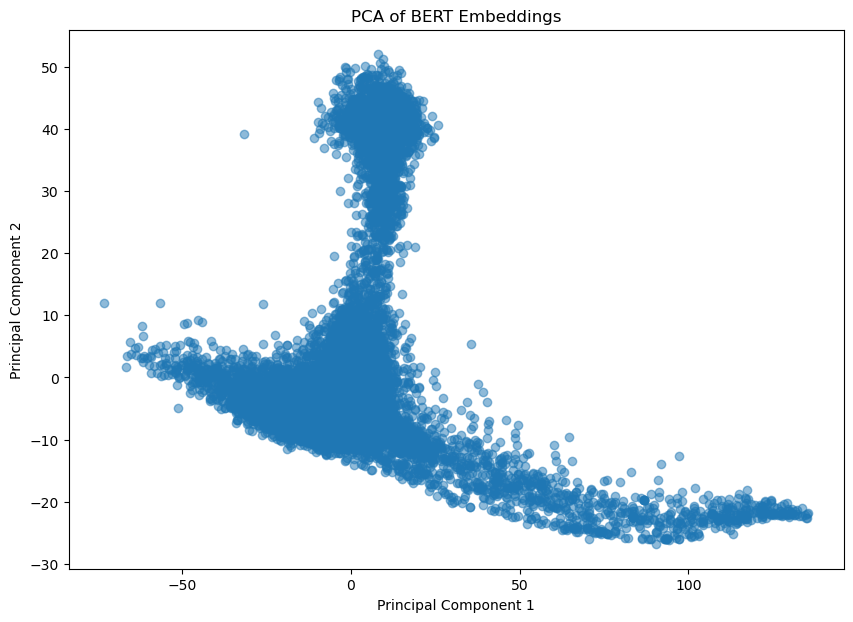

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X_tensor is your [22000, 768] PyTorch tensor
# Generate some random data for demonstration purposes
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array
X_np = X_features.numpy()

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

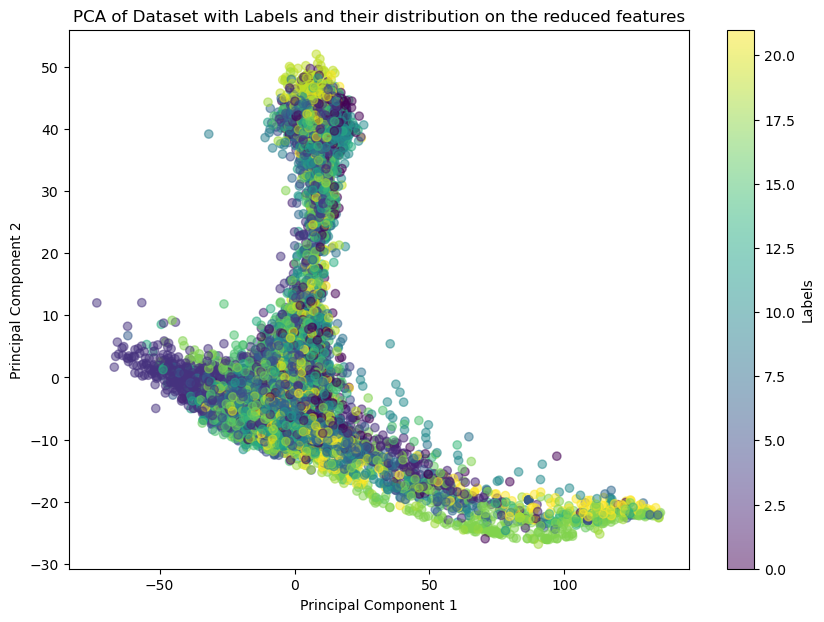

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the labels tensor to a NumPy array for plotting
y_np = y_labels_tensor.numpy()

# Assuming X_pca is the PCA-reduced data you computed earlier
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_np, alpha=0.5, cmap='viridis')
plt.title('PCA of Dataset with Labels and their distribution on the reduced features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Labels')
plt.show()


In [9]:
# Setting up device agnostic Tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
X_features= X_features.to(device) 
y_labels_tensor= y_labels_tensor.type(torch.LongTensor)
y_labels_tensor= y_labels_tensor.to(device)

In [11]:
X_features.device, y_labels_tensor.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [12]:

#Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels_tensor, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Step 3: Create TensorDatasets
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [15]:
len(X_train),len(X_test),len(y_train),len(y_test)

(15400, 6600, 15400, 6600)

In [16]:
y_train = y_train.to(device)
y_test = y_test.to(device)

In [17]:
y_test.device,y_train.device

(device(type='cuda', index=0), device(type='cuda', index=0))

## Construct a Feed forward Neural Network + Training

In [65]:
model = nn.Sequential(
    nn.Linear(768, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.5),  # Adjust dropout rate as needed

    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),

    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),

    nn.Linear(64, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),

    nn.Linear(32, 22),  # Replace 'number_of_classes' with the actual number
    nn.Softmax(dim=1)
)

In [67]:
model = model.to(device)

In [73]:
loss_entropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.1)

In [21]:
model

Sequential(
  (0): Linear(in_features=768, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=32, bias=True)
  (12): ReLU()
  (13): Linear(in_features=32, out_features=22, bias=True)
  (14): Softmax(dim=1)
)

In [83]:
epochs = 1200
epoch_count = []
train_losses = []
test_losses = []
best_loss = float('inf')
for epoch in range(epochs):
    epoch_count.append(epoch)
    model.train()
    initial_preds = model(X_train)
    train_loss = loss_entropy(initial_preds,y_train)
    train_losses.append(train_loss)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_entropy(test_pred,y_test)
        test_losses.append(test_loss)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_state = model.state_dict()
    if (epoch + 1) % 100 == 0:  # Adding 1 to epoch if your counting starts from 0
        print(f"** Epoch {epoch + 1} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}")
        


** Epoch 100 | Train Loss: 2.36963 | Test Loss: 2.36585
** Epoch 200 | Train Loss: 2.33545 | Test Loss: 2.32892
** Epoch 300 | Train Loss: 2.33777 | Test Loss: 2.32308
** Epoch 400 | Train Loss: 2.33900 | Test Loss: 2.32258
** Epoch 500 | Train Loss: 2.32257 | Test Loss: 2.31849
** Epoch 600 | Train Loss: 2.32439 | Test Loss: 2.32155
** Epoch 700 | Train Loss: 2.28605 | Test Loss: 2.28094
** Epoch 800 | Train Loss: 2.28859 | Test Loss: 2.27831
** Epoch 900 | Train Loss: 2.28799 | Test Loss: 2.28355
** Epoch 1000 | Train Loss: 2.29036 | Test Loss: 2.28080
** Epoch 1100 | Train Loss: 2.28550 | Test Loss: 2.28212
** Epoch 1200 | Train Loss: 2.28960 | Test Loss: 2.28890


In [87]:
best_loss


tensor(2.2743, device='cuda:0')

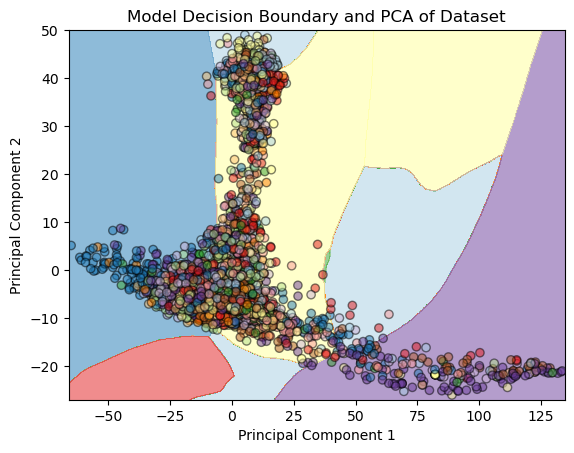

In [107]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X_tensor is your [22000, 768] PyTorch tensor and you have a corresponding labels tensor y_tensor
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array for features and labels
X_np = X_test.cpu().numpy()  # Move X_test tensor to CPU and then convert to NumPy array
y_np = y_test.cpu().numpy()  # Move y_test tensor to CPU and then convert to NumPy array


# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to plot decision boundary for a PyTorch model
def plot_decision_boundary_pytorch(X, y, model, device, steps=1000, cmap='Paired'):
    model.to(device)
    model.eval()  # Put the model in evaluation mode
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))

    # Preprocess grid points
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_original_space = pca.inverse_transform(grid)  # Transform back to original space
    grid_original_space = scaler.inverse_transform(grid_original_space)  # Inverse scaling
    grid_tensor = torch.tensor(grid_original_space, dtype=torch.float).to(device)

    # Predict using the PyTorch model
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        preds = np.argmax(preds, axis=1).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, preds, alpha=0.5, levels=np.unique(y), cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, edgecolor='k', cmap=cmap)
    plt.title('Model Decision Boundary and PCA of Dataset')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming `model` is your trained PyTorch model and `device` is your device ('cuda' or 'cpu')
plot_decision_boundary_pytorch(X_pca, y_np, model, device='cuda')  # Adjust 'cpu' to 'cuda' if using GPU


In [189]:
#loading the model's best state_dict from the trainig loop
model.load_state_dict(best_model_state)
model

Sequential(
  (0): Linear(in_features=768, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=22, bias=True)
)

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(epochs, train_loss, test_loss, title='Training and Test Loss', smooth_factor=0.6):
    """
    Plot the smoothed training and test loss over epochs.

    Parameters:
    - epochs: Number of epochs or a list of epoch indices.
    - train_loss: List or array of training loss values.
    - test_loss: List or array of test loss values.
    - title: Title of the plot.
    - smooth_factor: The weight factor for exponential moving average smoothing.
    """
    def smooth_curve(points, factor=smooth_factor):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    if isinstance(epochs, int):
        epochs = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, smooth_curve(train_loss), label='Train Loss', marker='o')
    plt.plot(epochs, smooth_curve(test_loss), label='Test Loss', marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

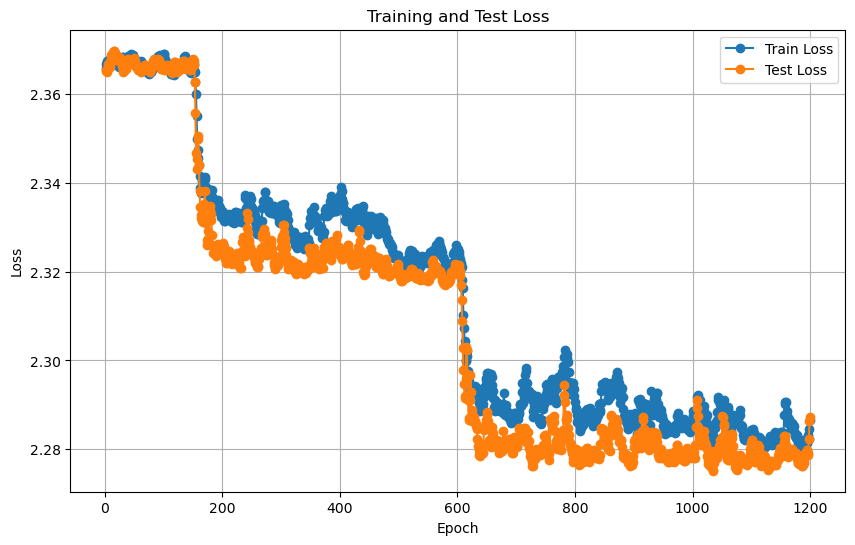

In [89]:
train_loss = []
test_loss = []
for train,test in zip(train_losses,test_losses):
    tensor_train = train.cpu().detach().numpy()
    tensor_test = test.cpu().detach().numpy()
    train_loss.append(tensor_train)
    test_loss.append(tensor_test)
plot_loss(epochs,train_loss,test_loss)

In [193]:
# saving model's parameter's in Local Machine
model_save_path = 'D:\\Master 2 TAL\\Neural networks\\project\\models\\my_model.pth'
torch.save(model.state_dict(), model_save_path)

## Testing Model Prediction

In [83]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Load the DistilBERT model
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

In [133]:
sentence = "wtf"

In [135]:
# Tokenizing and encoding raw sentence into tensor embeddings from DistilBert
encoded_input = tokenizer(sentence, return_tensors='pt')
output = distilbert_model(**encoded_input)
output

BaseModelOutput(last_hidden_state=tensor([[[ 1.2711e-01, -4.5752e-02,  6.6592e-01,  ...,  2.2343e-01,
           3.3231e-01, -2.1859e-02],
         [ 1.0918e-01, -2.1345e-01,  9.9493e-01,  ...,  1.7770e-01,
           6.5022e-01,  2.4072e-01],
         [-1.2856e-03, -2.1886e-01,  1.3439e+00,  ...,  5.6667e-01,
           7.6558e-01, -2.8033e-02],
         [ 3.7319e-02, -3.3888e-01,  1.2036e+00,  ...,  3.0068e-01,
           4.6546e-01,  1.3008e-01],
         [ 2.5160e-01, -2.3577e-01,  9.2509e-01,  ...,  9.2478e-03,
           4.0335e-01,  1.7343e-01]]], grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [137]:
# loading Bert tensor embeddings from DistilBert
sentence_embedding = output.last_hidden_state[:, 0, :]

In [139]:
# checking if the shape matches
sentence_embedding.shape

torch.Size([1, 768])

In [141]:
# predicting using the model
model.eval()
with torch.inference_mode():
    preds = model(sentence_embedding.to(device))
preds

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')

In [143]:
# Checking if it is the language used
predicted_index = preds.argmax()  # This finds the index of the maximum value in preds tensor, which is 0 in your case.
predicted_label = encoded_labels[predicted_index]
for label, encoded_label in label_mapping.items():
    if encoded_label == predicted_label:
        print(f"The language Predicted by the model is :{label}")

The language Predicted by the model is :Estonian
